In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import linecache
import math
import tensorflow as tf
from tensorflow.python.framework import ops
import pickle
%matplotlib inline

In [2]:
# initialize mode params
num_mode=3
ny=161
nz=23
y=np.zeros((ny,1))
z=np.zeros((nz,1))
data1=np.zeros((ny,nz))
data2=np.zeros((ny,nz))
mode_data=[['' for i in range(3)] for j in range(1)]

## file directory matching diff system distribution
file_str = '.*Mode_data*mode'
file_str_list = list(file_str)
index = 0
for cha in file_str_list:
    if cha == '*':
        file_str_list[index] = os.sep
    index += 1
file_str = ''.join(file_str_list)

In [3]:
# get mode1-3 E and H data
j=0
for i in range(3+1,3+1+ny):
    y[j,:]=linecache.getline(file_str+'1_ey.txt', i).split()
    j+=1

j=0
for i in range(3+ny+2+1,3+ny+2+1+nz):
    z[j,:]=linecache.getline(file_str+'1_ey.txt', i).split()
    j+=1

for k in range(num_mode):
    j=0
    for i in range(3+ny+2+nz+2+1,3+ny+2+nz+2+1+ny):
        data1[j,:]=linecache.getline(file_str+str(k+1)+'_ey.txt', i).split()
        j+=1  
    mode_data[0][k]=np.copy(data1.T)
sp_y=y.shape[0] # sampling points along y
sp_z=z.shape[0] # sampling points along z
# Normlize integral{|E|^2*dydz} to 1
dy=(y[-1,0]-y[0,0])/(y.shape[0]-1)
dz=(z[-1,0]-z[0,0])/(z.shape[0]-1)
norm_mode=np.zeros((1,num_mode))
for i in range(num_mode):
    norm_mode[0,i]=np.sum(mode_data[0][i]**2*dy*dz)
    mode_data[0][i]/=np.sqrt(norm_mode[0,i])

In [4]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [5]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [6]:
def build_graph(learning_rate):

    m = m_all
    
    x = tf.placeholder(tf.float32, shape=[None, 3, 21, 1])
    y_ = tf.placeholder(tf.float32, shape=[None, 3])
    
    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([3, 3, 1, 16]) # [filter_height, filter_width, in_channels, out_channels]
        b_conv1 = bias_variable([16])
        h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1) # [batch, 3, 21, 16]
        h_pool1 = max_pool_2x2(h_conv1) # [batch, 2, 11, 16]
    
    with tf.name_scope('conv2'):
        W_conv2 = weight_variable([3, 3, 16, 32])
        b_conv2 = bias_variable([32])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2) # [batch, 2, 11, 32]
        h_pool2 = max_pool_2x2(h_conv2) # [batch, 1, 6, 32]
        h_pool2_flat = tf.reshape(h_pool2, [-1, h_pool2.shape[1]*h_pool2.shape[2]*h_pool2.shape[3]])
    
    with tf.name_scope('fc1'):
        W_fc1 = weight_variable([np.int(h_pool2_flat.shape[-1]), 64])
        b_fc1 = bias_variable([64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        # dropout
        keep_prob_1 = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob_1)
        
    with tf.name_scope('fc2'):
        W_fc2 = weight_variable([64, 32])
        b_fc2 = bias_variable([32])
        h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
        # dropout
        keep_prob_2 = tf.placeholder(tf.float32)
        h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob_2)
        
    with tf.name_scope('fc3'):
        W_fc3 = weight_variable([32, 3])
        b_fc3 = bias_variable([3])
        y_conv = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
        y = tf.nn.softmax(y_conv)
    cost = tf.reduce_mean(tf.reduce_sum((y-y_)**2,axis=-1))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    return keep_prob_1, keep_prob_2, x, y_, y, cost, optimizer

In [7]:
num_data_set=100
m_base=100
m_all=m_base # number of all the samples
Y_test_set=np.zeros((num_data_set,3,m_all))
mode_comp_set=[''for i in range(num_data_set)]
A3_test=np.zeros((num_data_set,3,m_all))
cost_test=np.zeros((num_data_set,1))

tf.reset_default_graph()
keep_prob_1, keep_prob_2, x, y_, y, cost, optimizer = build_graph(learning_rate=1e-4)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, '.'+os.sep+'mc_regr_cnn'+os.sep+'model_2C2F1S'+os.sep+'model_min_tc_4')
    for i_data_set in range(num_data_set):
        np.random.seed(None) # random seed(0)
        rd1=np.random.randn(3,m_base)
        np.random.seed(None) # random seed(1)
        rd2=np.random.rand(3,m_base)
        mode_comp=np.zeros((num_mode,m_all),dtype=complex)
        mode_comp[:,:m_base]=np.abs(rd1)*np.exp(1j*rd2*2*np.pi)
        mode_comp_set[i_data_set]=np.copy(mode_comp)

        field_sp=[[0+1j for i in range(m_all)] for j in range(1)] # [[Ey(0),...,Ey(m_all-1)]]
        mode_comp_label=np.zeros((num_mode,m_all))
        for i in range(m_all):
            for j in range(num_mode):
                field_sp[0][i]+=mode_comp[j,i]*mode_data[0][j]
        mode_comp_label=np.abs(mode_comp)**2/np.sum(np.abs(mode_comp)**2,axis=0)

        ff_data=[]
        for i in range(m_all):
            ff_data.append(np.fft.fftshift(np.fft.fft2(field_sp[0][i]))/sp_y/sp_z)

        ff_i_data=['' for i in range(m_all)]
        for i in range(m_all):
            ff_i_data[i]=np.abs(ff_data[i])**2

        ff_i_data_eff=['' for i in range(m_all)]
        for i in range(m_all):
            ff_i_data_eff[i]=ff_i_data[i][9:12,70:91]
        ff_i_data_eff = np.array(ff_i_data_eff)

        X_test = -np.log10(ff_i_data_eff.reshape(m_all,ff_i_data_eff.shape[1],
                                                          ff_i_data_eff.shape[2],1))
        Y_test = mode_comp_label.T
        Y_test_set[i_data_set,:,:]=Y_test.T
        
        cost_test[i_data_set,0] = sess.run(cost,feed_dict={keep_prob_1: 1, keep_prob_2: 1, x: X_test, y_: Y_test})
        A3_test[i_data_set,:,:] = sess.run(y,   feed_dict={keep_prob_1: 1, keep_prob_2: 1, x: X_test, y_: Y_test}).T

INFO:tensorflow:Restoring parameters from .\mc_regr_cnn\model_2C2F1S\model_min_tc_4


In [8]:
import matplotlib
from numpy.random import randn
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = '{:.4}'.format(100 * y/num_data_set)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

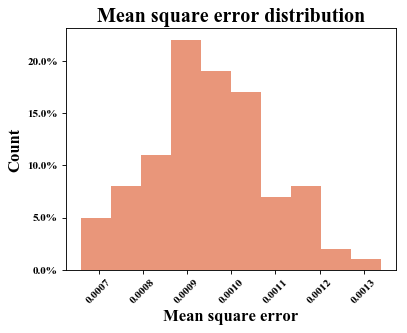

In [9]:
font_suptitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 18}
font_subtitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 15}
font_label = {'family' : 'Times New Roman',
              'weight' : 'bold',
              'size'   : 15}
font_tick = {'family' : 'Times New Roman',
             'weight' : 'semibold',
             'size'   : 10}

plt.figure(num=None, figsize=(8/1.5,6/1.5), dpi=80, facecolor='w', edgecolor='k')
plt.title('Mean square error distribution', **font_suptitle)
plt.xlabel('Mean square error', **font_label)
plt.ylabel('Count', **font_label)
plt.xticks(**font_tick,rotation=45)
plt.yticks(**font_tick)
plt.hist(cost_test,color='darksalmon')
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

In [10]:
max_error_index=np.argsort(np.squeeze(cost_test))[::-1]

[77 35 64 67 30 57 23  3 86 27]


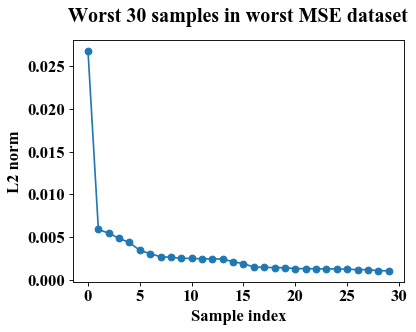

index_64:
[ 0.25963054  0.36317777  0.37719169] [ 0.20103215  0.40451288  0.39445496]


In [11]:
dsi=3
si = 2
worst_dataset=np.sum(np.abs(A3_test[max_error_index[dsi],:,:]-Y_test_set[max_error_index[dsi],:,:])**2,axis=0)
sar=np.argsort(worst_dataset)[-1:-11:-1] # sorted array
print(sar)
plt.figure(num=None, figsize=(8/1.5,6/1.5), dpi=80, facecolor='w', edgecolor='k')
font_suptitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 18}
font_subtitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 15}
font_label = {'family' : 'Times New Roman',
              'weight' : 'bold',
              'size'   : 15}
font_tick = {'family' : 'Times New Roman',
             'weight' : 'semibold',
             'size'   : 15}
plt.plot(np.sort(worst_dataset)[-30:][::-1],'o-')
plt.title('Worst 30 samples in worst MSE dataset',**font_suptitle,y=1.05)
plt.xlabel('Sample index',**font_label)
plt.ylabel('L2 norm',**font_label)
plt.xticks(**font_tick)
plt.yticks(**font_tick)
plt.show()

np.random.seed(None)
print("index_{}:".format(sar[si]))
print(Y_test_set[max_error_index[dsi],:,:].T[sar[si],:],A3_test[max_error_index[dsi],:,:].T[sar[si],:])

In [12]:
max_error_index.shape

(100,)

In [13]:
training_data_add=[]
dsi=0
si=0
for dsi in range(num_data_set):
    for si in range(m_all):
        worst_dataset=np.sum(np.abs(A3_test[max_error_index[dsi],:,:]-Y_test_set[max_error_index[dsi],:,:])**2,axis=0)
        sar=np.argsort(worst_dataset)[::-1] # sorted array
        if worst_dataset[sar[si]]>=5e-3:
            temp=mode_comp_set[max_error_index[dsi]][:,sar[si]]
            training_data_add.append(np.copy(temp))

            # Synthesis data set
            field_sp_inspect=np.zeros((23,161),dtype=np.complex)
            for i in range(num_mode):
                field_sp_inspect+=np.multiply(temp[i],mode_data[0][i])

            # view specified sample
            # plt.figure(num=None, figsize=(8/1.5,6/1.5), dpi=80, facecolor='w', edgecolor='k')
            # plt.title('Dataset_{}_sample_{}_|ey|'.format(max_error_index[dsi],sar[si]))
            # plt.imshow(np.abs(field_sp_inspect)/np.max(np.abs(field_sp_inspect)))
            # plt.gca().set_aspect('equal', adjustable='box')
            # plt.colorbar(orientation='horizontal')
            # plt.show()
            # print("Amplitude label: ")
            # print(np.array2string(100*Y_test_set[max_error_index[dsi],:,sar[si]], precision=2, separator=',', suppress_small=True))
            # print("Amplitude prediction: ")
            # print(np.array2string(100*A3_test[max_error_index[dsi],:,sar[si]], precision=2, separator=',', suppress_small=True))
            # print("Phase: ")      
            # print(np.angle(temp,deg=True))


In [14]:
len(training_data_add)

177

In [ ]:
# save training_data_add
f = open('.'+os.sep+'training_data_add'+os.sep+'training_data_add_1_111317', 'wb')
pickle.dump(training_data_add, f)
f.close()

In [15]:
import matplotlib
from numpy.random import randn
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = '{:.4}'.format(100 * y/m_all)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

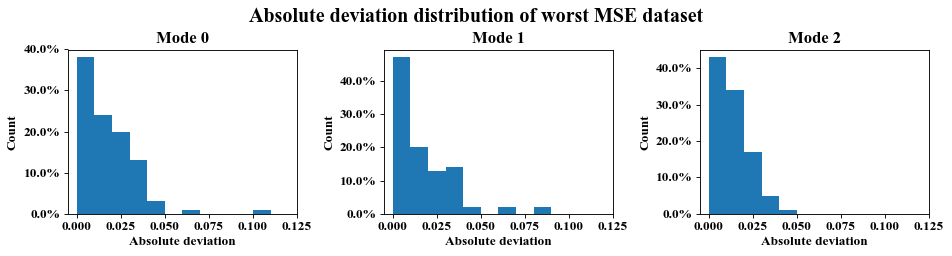

In [16]:
plt.figure(num=None, figsize=(12,3), dpi=80, facecolor='w', edgecolor='k')

font_suptitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 18}
font_subtitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 15}
font_label = {'family' : 'Times New Roman',
              'weight' : 'bold',
              'size'   : 12}
font_tick = {'family' : 'Times New Roman',
             'weight' : 'semibold',
             'size'   : 12}

plt.suptitle('Absolute deviation distribution of worst MSE dataset',x=0.5,y=1.05,**font_suptitle)

plt.subplot(1,3,1)
plt.hist(np.abs(A3_test[max_error_index[0],0,:]-Y_test_set[max_error_index[0],0,:]),bins=12,range=(0,0.12))
plt.title('Mode 0',**font_subtitle)
plt.xlabel('Absolute deviation',**font_label)
plt.ylabel('Count',**font_label)
plt.xlim(-0.005,0.125)
plt.xticks(**font_tick)
plt.yticks(**font_tick)
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(1,3,2)
plt.hist(np.abs(A3_test[max_error_index[0],1,:]-Y_test_set[max_error_index[0],1,:]),bins=12,range=(0,0.12))
plt.title('Mode 1',**font_subtitle)
plt.xlabel('Absolute deviation',**font_label)
plt.ylabel('Count',**font_label)
plt.xlim(-0.005,0.125)
plt.xticks(**font_tick)
plt.yticks(**font_tick)
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(1,3,3)
plt.hist(np.abs(A3_test[max_error_index[0],2,:]-Y_test_set[max_error_index[0],2,:]),bins=12,range=(0,0.12))
plt.title('Mode 2',**font_subtitle)
plt.xlabel('Absolute deviation',**font_label)
plt.ylabel('Count',**font_label)
plt.xlim(-0.005,0.125)
plt.xticks(**font_tick)
plt.yticks(**font_tick)
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()